In [19]:
import xlfluor as xlf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import lmfit
import pandas as pd

global DEBUG
DEBUG = True

%matplotlib notebook

## Defining the Cavity

In [2]:
vacuum = xlf.Vacuum()
carbon = xlf.Element(name = 'c', Z= 6, atom_weight = 12.011,density = 2.2*1e3) # the factor 1e3 converts from g/cm3 to Kg/m3
silicon = xlf.Element(name = 'si', Z= 14, atom_weight = 28.086,density = 2.33*1e3)
iron = xlf.Element(name = 'fe', Z = 26, atom_weight=55.845, density=7.87*1e3)
oxygen = xlf.Element(name = 'o', Z = 8, atom_weight=15.999, density=0.143E-02*1e3) # Oxygen density is as gas!!
platinum = xlf.Element(name = 'pt', Z = 78, atom_weight=195.078, density=21.5*1e3)

iron_oxide = xlf.Composite(name = 'fe2o3', elements=[iron, oxygen], density=5.07*1e3, composition =[2,3])

layer_list_custom = [
    xlf.Layer(platinum, 2.8 * 1e-9, density=21.0e3),
    xlf.Layer(carbon, 31.26 * 1e-9, density=1.7e3),
    xlf.Layer(iron_oxide, 3.9 * 1e-9, inelastic_cross=0.4e9, density=4.5e3),
    xlf.Layer(carbon, 34.136 * 1e-9, density=1.6e3),
    xlf.Layer(platinum, 15 * 1e-9, density=21.00e3),
    xlf.Layer(silicon, np.inf, density = 2.33*1e3, final = True)
]
layer_list_custom2 = [
    xlf.Layer(platinum, 1.755 * 1e-9, density=20.5e3),
    xlf.Layer(carbon, 31.26 * 1e-9, density=1.656e3),
    xlf.Layer(iron_oxide, 3.9 * 1e-9, inelastic_cross=0.4e9, density=4.309e3),
    xlf.Layer(carbon, 34.136 * 1e-9, density=1.589e3),
    xlf.Layer(platinum, 15 * 1e-9, density=20.50e3),
    xlf.Layer(silicon, np.inf, density = 2.614*1e3, final = True)
]

cavity = xlf.Cavity(layer_list_custom2)



pt Layer Initiated.
c Layer Initiated.
fe2o3 Layer Initiated.
c Layer Initiated.
pt Layer Initiated.
si Layer Initiated.
pt Layer Initiated.
c Layer Initiated.
fe2o3 Layer Initiated.
c Layer Initiated.
pt Layer Initiated.
si Layer Initiated.
Cavity Initiated.


## Loading Experimental Data for Fitting

In [3]:

#### Let us read some experimental data for comparison
keys = ['dt', 'dtz', 'fluor_diode', 'izero_diode', 'refl', 'scanNr',
       'sry', 'sty']
loaded_scan_mat = np.loadtxt('scan_486_wide_angle_diode.txt')
loaded_scan = {}
for i, key in enumerate(keys):
    loaded_scan[key] = loaded_scan_mat[1:,i]

experiment_data = {
    'fluor_diode': xlf.normmax(loaded_scan['fluor_diode']),
    'refl': xlf.normmax(loaded_scan['refl']),
    'angles_in': np.array(loaded_scan['sry'])
}


##### Accounting for experimental offset
# In this dataset it appears that the "sry" motor was offset by 0.025°
experiment_data['angles_in'] = xlf.deg2rad(experiment_data['angles_in'] - 0.025)

## Define Axes
The axis defined here will only be regarded if the same axes are not specified in the experiment data.

In [4]:

energies_in=np.array([7150])
energies_out=np.array([6400])
angles_in  = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(0.55),300) #np.array([xlf.deg2rad(0.3)])#
angles_out = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(1.0),300) #np.array(xlf.deg2rad(np.array([0.2,0.3])))#
#xlf.deg2rad(np.array([0.3,0.300001]))#
axes = {'energies_in': energies_in,
        'energies_out': energies_out,
        'angles_in': angles_in,
        'angles_out':angles_out}

## Instantiate Problem and parameters

In [5]:
# Construc the problem object
my_problem = xlf.Problem(cavity, experiment_data = experiment_data, axes=axes,\
                         passive_layer_resolution = 30, active_layer_resolution = 10)

# Get a set of parameters based on the layer list defined above
parameters = cavity.parameters

# Calculate an initial solution
my_problem.solve(cavity, parameters)

# Get the relative intensities of fluorescence and reflectivity
cavity.get_relative_intensities(my_problem)

cavity.set_fit_weigths(weight_refl = 1, weight_fluor = 2)


Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
ProblemSolution Initiated.
Based on the Initial fit, setting relative intensity of refl and fluor 
 to 0.9285467215887053 and 0.14343115192473418, respectively


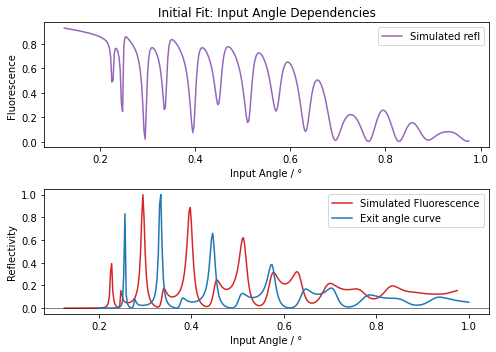

In [6]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = experiment_data['fluor_diode']#*cavity.parameters['I_fluorescence']
exp_refl = experiment_data['refl']#*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
#ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
#ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, xlf.normmax(model_fluor), c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


##########Exit angle

ax2.plot(xlf.rad2deg(my_problem.angles_out),\
         xlf.normmax(xlf.abs2(np.nansum(my_problem.cavity.solution.fluorescence_emitted_amplitude,(0,1,2))))\
         , label = 'Exit angle curve')
plt.legend()

In [7]:
np.nanmax(my_problem.cavity.solution.consistency_check())

(2.9569491744041443e-08-2.0481820683926344e-08j)

## Detailed Plots

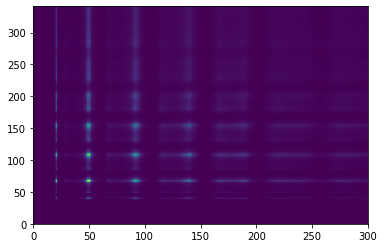

In [8]:
plt.figure()
plt.pcolormesh(xlf.abs2(my_problem.cavity.solution.fluorescence_emitted_amplitude[0,0,:,:]))

In [9]:
#plt.figure()
#plt.pcolormesh(np.sum(xlf.abs2(my_problem.cavity.solution.fluorescence_local_amplitude[0,0,:,:,my_problem.z_layer_indices==2,:])[4,:,:,:],(2)))

In [10]:
xlf.abs2(my_problem.cavity.solution.fluorescence_local_amplitude[0,0,:,:,my_problem.z_layer_indices==2,:]).shape

(10, 341, 300, 2)

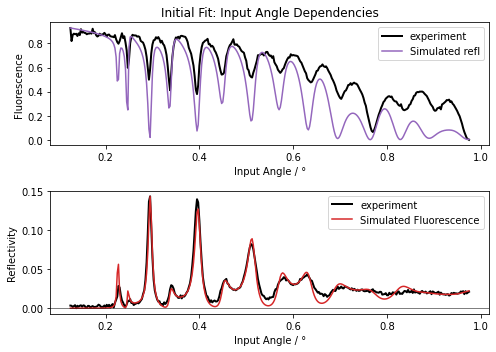

In [11]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = my_problem.experiment['fluor_diode']*cavity.parameters['I_fluorescence']
exp_refl = my_problem.experiment['refl']*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, model_fluor, c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


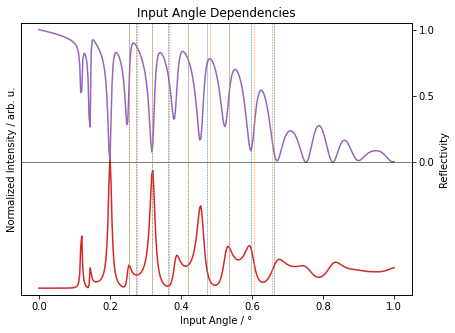

In [12]:



###################################################
##### Diode trace plots
###################################################
plt.figure(figsize=(7, 5))
ax1 = plt.gca()
plt.ylabel('Normalized Intensity / arb. u.')
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C4-',
         label='Simulated Reflectivity')  # dummy plots for legend
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C0--',
         label='Measured Reflectivity')

plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)), c='C3',
         label='Simulated Fluorescence')
data_shift = 0

# plt.ylim(None,6)
plt.xlabel('Input Angle / °')
plt.title(f'Input Angle Dependencies')
plt.yticks([])
plt.ylim(None, 2)

ax2 = plt.gca().twinx()
plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.reflectivity)[0,:]), 'C4-', label='Simulated refl')
plt.ylabel('Reflectivity')
plt.ylim(-1, None)
plt.yticks([0, 0.5, 1])
plt.axhline(c='k', lw=.5)

mode_angles = [.253, .2725, .317, .3625, .420, .474, .536, .598, .662]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C0', ls='--')
mode_angles = [.253, .276, .318, .365, .420, .482, .536, .606, .655]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C1', ls='--')




In [13]:
cavity.solution.incident_field_amplitude.shape

(1, 341, 133)

(80.0, 0.02925)

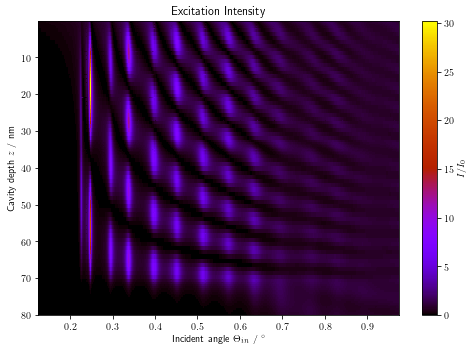

In [14]:

mpl.rcParams['text.usetex'] = True

plt.figure(figsize = (7,5))
plt.pcolormesh(xlf.rad2deg(my_problem.angles_in),my_problem.z_axis*1e9, xlf.abs2(cavity.solution.incident_field_amplitude[0,:,:]).T,\
               cmap = 'gnuplot', shading = 'nearest')#norm = mpl.colors.LogNorm(),

plt.ylabel('Cavity depth $z$ / nm')
plt.xlabel('Incident angle $ { \Theta}_{in}$ / $^\circ$')
plt.title('Excitation Intensity')
plt.colorbar(label='$I / I_0$')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.ylim(80,None)


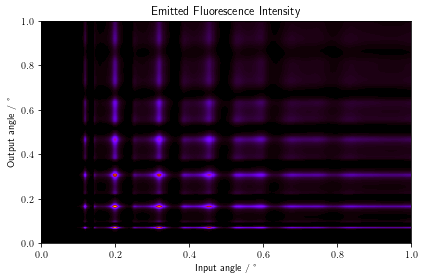

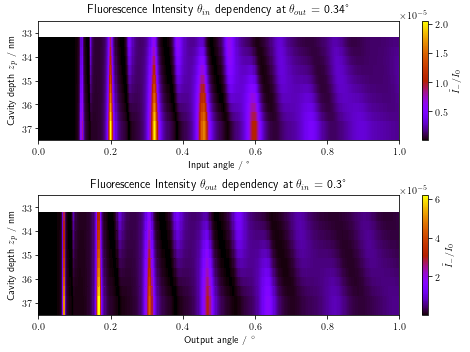

In [15]:


#####################################################
######### 2d Plot
################################################
plotmat = xlf.abs2(cavity.solution.fluorescence_emitted_amplitude[0,0,:,:])
#plotmat = xlf.abs2(np.nansum(cavity.solution.fluorescence_local_amplitude[0,0,:,:,:,0],2)) # sum over depth of non-propagated fluorescence
#plotmat = cplxsq(my_problem.fluor_emitted_from_z[:,:,:])
#plotmat = cplxsq(np.sum(my_problem.fluor_emitted_from_z[:,:,:],0))

plt.figure()
plt.pcolormesh(xlf.normmax(my_problem.angles_in),xlf.normmax(my_problem.angles_out),\
               plotmat.T, cmap = 'gnuplot', shading = 'nearest')#,vmax=4e3)#norm = mpl.colors.LogNorm(vmin = 0.005)
plt.ylabel('Output angle / °')
plt.xlabel('Input angle / °')
plt.title('Emitted Fluorescence Intensity')
#plt.colorbar(label=r'$\tilde{I} / I_0$')
plt.tight_layout()


#########################################


example_angle_in = xlf.deg2rad(0.3)
example_angle_in_index = np.argmin(np.abs(example_angle_in-my_problem.angles_in))

example_angle_out = xlf.deg2rad(0.342)
example_angle_out_index = np.argmin(np.abs(example_angle_out-my_problem.angles_out))



fig, axes = plt.subplots(2,1, figsize = (7,5))
plt.sca(axes[0])
plt.pcolormesh(xlf.normmax(my_problem.angles_in),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,:,example_angle_out_index,:]).T,shading = 'nearest',cmap = 'gnuplot')
plt.axvline(xlf.normmax(example_angle_in), ls = '--', lw= 1, c='grey')

plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Input angle / °')
plt.title(r'Fluorescence Intensity $\theta_{in}$ dependency at $\theta_{out}$ ='+f' {xlf.rad2deg(my_problem.angles_out[example_angle_out_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,37.5)
plt.tight_layout()
plt.gca().invert_yaxis()

plt.sca(axes[1])
plt.pcolormesh(xlf.normmax(my_problem.angles_out),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,example_angle_in_index,:,:]).T,shading = 'nearest', vmax=None,cmap = 'gnuplot')#, norm = mpl.colors.LogNorm()
plt.axvline(xlf.normmax(example_angle_out), ls = '--', lw= 1, c='grey')
plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Output angle / $^\circ$')
plt.title(r'Fluorescence Intensity $\theta_{out}$ dependency at $\theta_{in}$ ='+f' {xlf.rad2deg(my_problem.angles_in[example_angle_in_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,37.5)
plt.tight_layout()
plt.gca().invert_yaxis()



plt.show()

In [16]:
my_problem.angles_in[example_angle_in_index]

0.005235289508434683

<IPython.core.display.Javascript object>


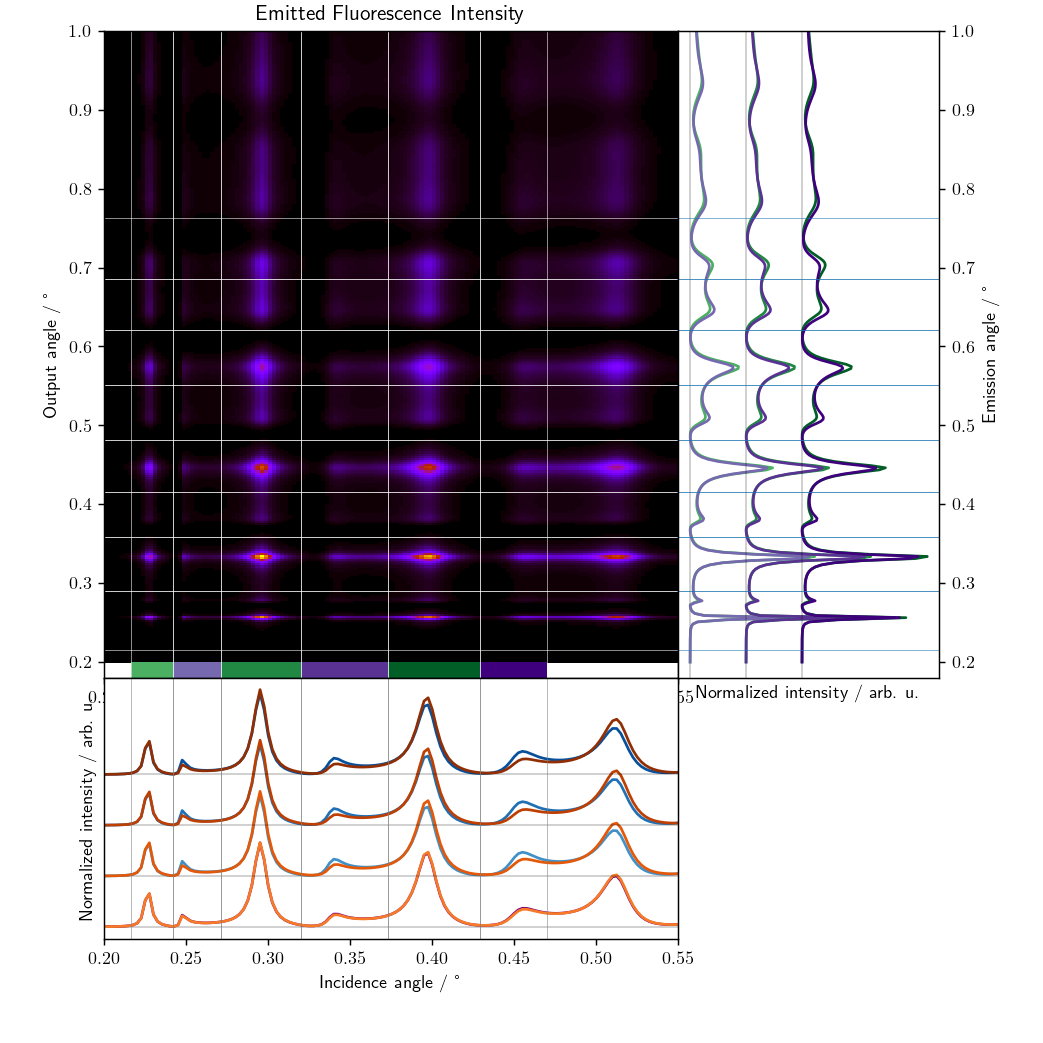

In [20]:
data_shift = 0.025
data_shift_out = 0.035

#####


import hyperspy.api as hs

y = xlf.rad2deg(my_problem.angles_in)
x = xlf.rad2deg(my_problem.angles_out)

def linearize_axis(vec, plot=False):
    x = np.arange(len(vec))
    fit = np.polyfit(x,vec,1)
    if plot:
        plt.figure()
        plt.plot(x,vec,label='given')
        plt.plot(x,np.polyval(fit,x),label = 'fit')
        err=vec-np.polyval(fit,x)
        plt.plot(x,100*(err),label='error *100')
        print(f'Max Error was: {np.max(err)}')
    return fit

a_in_axis_dict = {'size': len(y), 'name':'Thin', 'units':'°', 'scale':linearize_axis(y)[0], 'offset':linearize_axis(y)[1]}
a_out_axis_dict = {'size': len(x), 'name':'Thout', 'units':'°', 'scale':linearize_axis(x)[0], 'offset':linearize_axis(x)[1]}


hsmat_fluor_A= hs.signals.BaseSignal(my_problem.cavity.solution.fluorescence_emitted_amplitude[0,0,...], axes = [a_in_axis_dict,a_out_axis_dict])
hsmat_fluor_I= hs.signals.BaseSignal(xlf.abs2(hsmat_fluor_A.data), axes = [a_in_axis_dict,a_out_axis_dict])

########### Figure configureation
# definitions for the axes
left, width = 0.1, 0.55
bottom, height = 0.35, 0.62
spacing = 0.00


rect_scatter = [left, bottom, width, height]
rect_ain = [left, 0.1, width, 0.25]
rect_aout = [left + width + spacing, bottom, 0.25, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_ain = fig.add_axes(rect_ain, sharex=ax)
ax_aout = fig.add_axes(rect_aout, sharey=ax)
ax_aout.yaxis.tick_right()
ax_aout.yaxis.set_label_position("right")
ax_aout.yaxis.tick_right()



################### Area Plot
plt.sca(ax)

plt.pcolormesh(xlf.rad2deg(my_problem.angles_in),xlf.rad2deg(my_problem.angles_out),\
               plotmat.T, cmap = 'gnuplot')#,norm = mpl.colors.LogNorm(vmin = 0.005))#,vmax=4e3)#
plt.ylabel('Output angle / °')
plt.xlabel('Input angle / °')
plt.title('Emitted Fluorescence Intensity')
#plt.colorbar(label=r'$\tilde{I} / I_0$')
plt.tight_layout()

### Ich plotte einfach mal ein paar output moden nebeneinander

omode1_th = .25-data_shift_out, .325-data_shift_out
omode2_th = .325-data_shift_out, .394-data_shift_out
omode3_th = .394-data_shift_out, .450-data_shift_out
omode4_th = .450-data_shift_out, .516-data_shift_out
omode5_th = .516-data_shift_out, .586-data_shift_out
omode6_th = .586-data_shift_out, .656-data_shift_out
omode7_th = .656-data_shift_out, .720-data_shift_out
omode8_th = .720-data_shift_out, 0.798-data_shift_out
#omode9_th = 1.25 , 2.25
hsmats_omodes = {}

omode_colors_1 = mpl.cm.Blues(np.linspace(.5,1,9))
omode_colors_2 = mpl.cm.Oranges(np.linspace(.5,1,9))

for i in np.arange(8):
    color = omode_colors_1[i] if np.mod(i,2)==0 else omode_colors_2[i]

    moderange = eval(f'omode{i+1}_th')
    plt.axhline(moderange[0], c= f'white',lw=.3)
    plt.axhline(moderange[1], c= f'white',lw=.3)
    plt.fill_between(x = [np.min(y)-0.012,np.min(y)],y1=moderange[0],y2=moderange[1],\
                     color=color if i>0 else 'Purple',lw=0)
    
    hsmats_omodes[i] = hsmat_fluor_I.isig[moderange[0]:moderange[1],:].mean('Thout')
    
## Jetzt die input moden

imode_colors_1 = mpl.cm.Greens(np.linspace(.6,1,6))
imode_colors_2 = mpl.cm.Purples(np.linspace(.6,1,6))

imode1_th = .241-data_shift, .267-data_shift
imode2_th = .267-data_shift, .296-data_shift
imode3_th = .296-data_shift, .345-data_shift
imode4_th = .345-data_shift, .398-data_shift
imode5_th = .398-data_shift, .454-data_shift
imode6_th = .454-data_shift, .495-data_shift

hsmats_imodes = {}

for i in np.arange(6):
    moderange = eval(f'imode{i+1}_th')
    plt.axvline(moderange[0], c= f'white',lw=.3)
    plt.axvline(moderange[1], c= f'white',lw=.3)
    
    color = imode_colors_1[i] if np.mod(i,2)==0 else imode_colors_2[i]
    plt.fill_betweenx(y = [0.172,0.2],x1=moderange[0],x2=moderange[1],color=color,lw=0)

    hsmats_imodes[i] = hsmat_fluor_I.isig[:,moderange[0]:moderange[1]].mean('Thin')
    
    
plt.xlim(.2-0.012,np.max(y))#0.5
plt.ylim(.2-0.02,1.0)
plt.tight_layout()


################### Angle In Plot
plt.sca(ax_ain)

offset = 0.5

crange1 = omode_colors_1 #mpl.cm.Blues(np.linspace(.4,1,9))
crange2 = omode_colors_2 #mpl.cm.Oranges(np.linspace(.4,1,9))

def custom_norm(y):
    y = np.array(y)
    y=y-np.min(y)
    #y=y/y[np.argmax(y[:50])]
    y=0.25*y/np.mean(y)
    return y

for i in range(8):
    color = crange1[i] if np.mod(i,2)==0 else crange2[i]
    inmode_proj = hsmat_fluor_I.mean('Thout')#my_problem.fluotescence_I_angle_in_dependent
    inmode_proj_ka1 = hsmats_omodes[i]
    
    spec = custom_norm(inmode_proj_ka1)

    plt.plot(hsmats_omodes[i].axes_manager['Thin'].axis,spec+(i+1-np.mod(i,2))*offset,\
             c=color if i>0 else 'purple',ls='-',label = f'Mode {i+2}' if i>0 else f'Modes 1&2')

    if np.mod(i,2)==0:
        plt.axhline((i+1)*offset,lw=.2,c='k')

    
plt.xlim(0.2,0.55)
#plt.legend(loc='upper left',fontsize=10,framealpha =.5)
plt.xlabel('Incidence angle / °')
plt.ylabel('Normalized intensity / arb. u.')
plt.yticks([])
plt.tight_layout()




for i in np.arange(6):
    moderange = eval(f'imode{i+1}_th')
    plt.axvline(moderange[0], c= f'grey',lw=.3)
    plt.axvline(moderange[1], c= f'grey',lw=.3)

    
########## Angle Out plot
plt.sca(ax_aout)


crange1 = imode_colors_1 #mpl.cm.Blues(np.linspace(.4,1,9))
crange2 = imode_colors_2 #mpl.cm.Oranges(np.linspace(.4,1,9))
def custom_norm(y):
    y = np.array(y)
    y=y-np.nanmin(y)
    #y=y/y[np.argmax(y[:50])]
    y=0.25*y/np.nanmean(y[:180])
    return y

for i in range(6):
    color = crange1[i] if np.mod(i,2)==0 else crange2[i]
    
    outmode_proj = hsmat_fluor_I.mean('Thin')#my_problem.fluotescence_I_angle_out_dependent
    outmode_proj_ka1 = hsmats_imodes[i]


    plt.plot(custom_norm(outmode_proj_ka1)+(i+1-np.mod(i,2))*offset,\
             x,\
             c=color ,ls='-',label = f'Mode {i+1}')

    if np.mod(i,2)==0:
        plt.axvline((i+1)*offset,lw=.2,c='k')

    
#plt.legend(loc='upper left',fontsize=10,framealpha =.5)
plt.ylabel('Emission angle / °')
plt.xlabel('Normalized intensity / arb. u.')
plt.xticks([])

for i in np.arange(8):
    moderange = eval(f'omode{i+1}_th')
    plt.axhline(moderange[0], c= f'C0',lw=.3)
    plt.axhline(moderange[1], c= f'C0',lw=.3)
    
plt.tight_layout()

#plt.savefig('./plots/Output Angle Structure.pdf')